## The Backfield Demagnetization Experiment

The backfield demagnetization experiment is a standard rock magnetic procedure used to characterize the coercivity distribution of magnetic minerals in a sample. It provides insight into magnetic mineralogy, grain size, and domain state by quantifying how resistant the remanent magnetization is to reversal.


### Experimental procedure
1. **Saturation**
   The specimen is first exposed to a large positive DC magnetic field (typically 1 to 2 T) to impart a **Saturation Isothermal Remanent Magnetization (SIRM)**.
2. **Stepwise reverse field application**
   A magnetic field is then applied in the opposite (negative) direction in progressively larger steps. After each reverse field step, the field is turned off and the remaining remanent magnetization $M_r$ is measured.
3. **Backfield curve**
   Plotting the remanent magnetization $M_r$ versus the applied reverse field produces the **backfield demagnetization curve**. As the reverse field magnitude increases, progressively higher-coercivity grains switch direction, reducing the net remanence.

### Coercivity of remanence ($B_{cr}$)

The **coercivity of remanence**, $B_{cr}$, is defined as the magnitude of the reverse field required to reduce the remanent magnetization to zero. Physically, it reflects the median switching field of the remanence-carrying population.

Because $B_{cr}$ is measured after the applied field is removed, it isolates the irreversible switching behavior of magnetic grains — unlike in-field parameters such as $B_c$, which include contributions from grains that deflect in the field but spring back when it is removed. This makes $B_{cr}$ one of the most commonly reported parameters in rock magnetic studies and a key input to diagnostic frameworks such as the Day plot ($M_{rs}/M_s$ vs. $B_{cr}/B_c$).

Low-coercivity ("soft") minerals lose remanence at small reverse fields, whereas high-coercivity ("hard") minerals persist to larger fields. The full shape of the backfield curve therefore contains information beyond $B_{cr}$ alone and motivates analysis of the underlying coercivity spectrum.

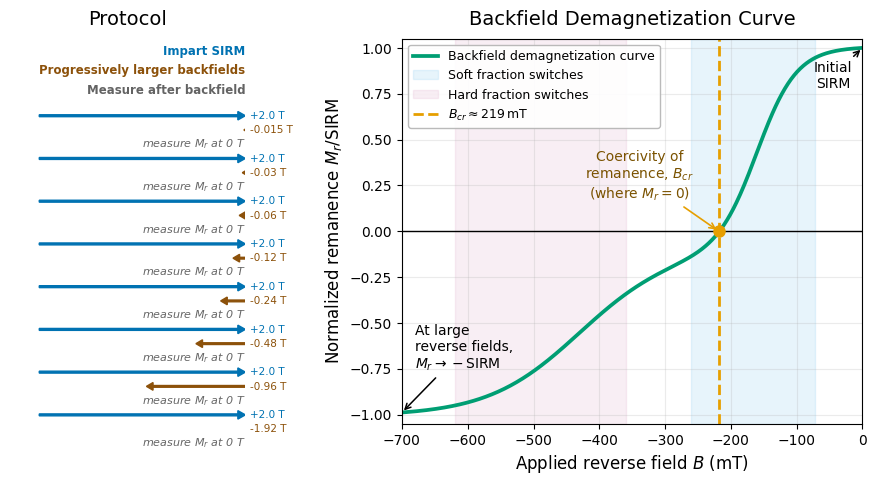

In [1]:
#@title Backfield Demagnetization (Conceptual)
import numpy as np
import matplotlib.pyplot as plt

def logistic(x, x0, k):
    return 1 / (1 + np.exp(-(x - x0) / k))

# --- Conceptual backfield curve ---
Bmag = np.linspace(0, 700, 600)  # |B| (mT)
soft = 0.55 * logistic(Bmag, x0=160, k=30)
hard = 0.45 * logistic(Bmag, x0=430, k=70)
Mr = 1 - 2 * (soft + hard)
Mr = Mr / Mr[0]  # normalize so curve starts at exactly 1.0
B = -Bmag  # signed backfield axis

# B_cr from M_r = 0
idx = np.where(np.diff(np.signbit(Mr)))[0]
if len(idx) > 0:
    i = idx[0]
    Bcr_mag = np.interp(0, [Mr[i], Mr[i + 1]], [Bmag[i], Bmag[i + 1]])
    Bcr = -Bcr_mag
else:
    Bcr_mag = np.nan
    Bcr = np.nan

# Figure layout
fig = plt.figure(figsize=(11.0, 5.0))
gs = fig.add_gridspec(1, 2, width_ratios=[1.15, 2.25], wspace=0.45)

# --- Left panel: protocol ---
axL = fig.add_subplot(gs[0, 0])
axL.set_xlim(0, 1)
axL.set_ylim(0, 1)
axL.axis("off")
axL.set_title("Protocol", fontsize=14, pad=10, loc="center")

n_pairs = 8
y0, dy = 0.8, 0.037
blue_field_T = 2.0                   # scale reference for blue arrow (+2.0 T)
brown_fields_mT = np.array([-15, -30, -60, -120, -240, -480, -960, -1920], dtype=float)
brown_fields_T = brown_fields_mT / 1000.0

# Place caption text right-justified, then measure width to set arrow length
caption_blue = axL.text(1.0, 0.95, "Impart SIRM", fontsize=8.5,
                        va="bottom", ha="right",
                        color="#0072B2", fontweight="bold")
caption_brown = axL.text(1.0, 0.9, "Progressively larger backfields",
                         fontsize=8.5, va="bottom", ha="right",
                         color="#8C510A", fontweight="bold")
caption_blue = axL.text(1.0, 0.85, "Measure after backfield", fontsize=8.5,
                        va="bottom", ha="right",
                        color="#636363", fontweight="bold")

# Render once to measure the brown caption width in axes coords
fig.canvas.draw()
renderer = fig.canvas.get_renderer()
bb = caption_brown.get_window_extent(renderer)
bb_axes = axL.transData.inverted().transform(bb)
blue_len = bb_axes[1, 0] - bb_axes[0, 0]  # text width in axes coords

x_right = 1.0                        # arrows right-aligned with caption text
blue_start = x_right - blue_len

# Brown arrow lengths on same field scale as blue
brown_lens = blue_len * (np.abs(brown_fields_T) / blue_field_T)

for k in range(n_pairs):
    y_blue = y0 - (3 * k) * dy
    y_brown = y0 - (3 * k + 1) * dy
    y_meas = y0 - (3 * k + 2) * dy

    # +SIRM step (right-pointing)
    axL.arrow(
        blue_start, y_blue, blue_len, 0,
        width=0.0050, head_width=0.022, head_length=0.032,
        length_includes_head=True, color="#0072B2"
    )

    # Reverse backfield step (left-pointing)
    axL.arrow(
        x_right, y_brown, -brown_lens[k], 0,
        width=0.0045, head_width=0.020, head_length=0.028,
        length_includes_head=True, color="#8C510A"
    )

    # Field labels past arrow tips
    axL.text(x_right + 0.02, y_blue, f"+{blue_field_T:.1f} T",
             fontsize=7.5, color="#0072B2", va="center", ha="left")
    axL.text(x_right + 0.02, y_brown, f"{brown_fields_T[k]:.3g} T",
             fontsize=7.5, color="#8C510A", va="center", ha="left")

    # Measure step — right-aligned
    axL.text(1.0, y_meas, r"measure $M_r$ at 0 T",
             fontsize=8, color="#666666", va="center", ha="right",
             fontstyle="italic")

# --- Main panel ---
ax = fig.add_subplot(gs[0, 1])
ax.plot(B, Mr, color="#009E73", lw=2.7, label="Backfield demagnetization curve")
ax.axhline(0, color="black", lw=1)

ax.axvspan(-260, -72, color="#56B4E9", alpha=0.14, label="Soft fraction switches")
ax.axvspan(-620, -360, color="#CC79A7", alpha=0.12, label="Hard fraction switches")

if np.isfinite(Bcr):
    ax.axvline(Bcr, color="#E69F00", lw=2, ls="--",
               label=fr"$B_{{cr}} \approx {Bcr_mag:.0f}\,\mathrm{{mT}}$")
    ax.plot(Bcr, 0, "o", color="#E69F00", ms=8)
    # label close to Bcr point, offset just above
    ax.annotate(
        r"Coercivity of" + "\n"
        + r"remanence, $B_{cr}$" + "\n"
        + r"(where $M_r = 0$)",
        xy=(Bcr, 0), xytext=(Bcr - 120, 0.18),
        arrowprops=dict(arrowstyle="->", lw=1.2, color="#E69F00"),
        fontsize=10, color="#7A5200", ha="center"
    )

# SIRM label — shifted right, close to curve start
ax.annotate(
    "Initial\nSIRM",
    xy=(0, Mr[0]), xytext=(-45, 0.78),
    arrowprops=dict(arrowstyle="->", lw=1.1), fontsize=10,
    ha="center"
)

# -SIRM label — shifted left, close to endpoint
ax.annotate(
    r"At large" + "\n" + r"reverse fields," + "\n" + r"$M_r \rightarrow -$SIRM",
    xy=(B[-1], Mr[-1]), xytext=(-680, -0.75),
    arrowprops=dict(arrowstyle="->", lw=1.1), fontsize=10
)

ax.set_title("Backfield Demagnetization Curve", fontsize=14, pad=10)
ax.set_xlabel(r"Applied reverse field $B$ (mT)", fontsize=12)
ax.set_ylabel(r"Normalized remanence $M_r$/SIRM", fontsize=12)
ax.set_xlim(-700, 0)
ax.set_ylim(-1.05, 1.05)
ax.grid(alpha=0.25)
ax.legend(loc="upper left", frameon=True, fontsize=9,
          facecolor="white", edgecolor="0.7", framealpha=0.9)
plt.show()

## Backfield analysis of the Mirbat Group specimens

In this notebook, we will analyze backfield demagnetization data collected by Mary Yao on samples from the Mirbat Group of Oman. These data were measured at the Institute for Rock Magnetism using a vibrating sample magnetometer (VSM). The dataset is formatted following the MagIC data model and hosted on GitHub.

We will use the `pmagpy` library to load and process the data, interactively select specimens and experiments, determine the coercivity of remanence ($B_{cr}$), and examine the underlying coercivity distributions through unmixing analysis.

In [2]:
!pip install --upgrade pmagpy

In [3]:
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pmagpy.rockmag as rmag
import pmagpy.contribution_builder as cb

import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

-W- cartopy is not installed
    If you want to make maps, install using conda:
    conda install cartopy


In [4]:
# 1. Define the URL and local filename
url = "https://raw.githubusercontent.com/Institute-for-Rock-Magnetism/2026_ESCI_pmag_course/refs/heads/main/W6_magnetic_minerals/Oman_Mirbat_2024.TXT"
filename = "Oman_Mirbat_2024.TXT"

# 2. Download the file
print(f"Downloading {filename}...")
response = requests.get(url)
with open(filename, 'wb') as f:
    f.write(response.content)
print("Download complete.")

# 3. Unpack the MagIC contribution
# This extracts 'measurements.txt', 'specimens.txt', etc. into the current directory
print("Unpacking MagIC contribution...")
ipmag.download_magic(filename)
print("Unpacking complete. Check your directory for 'measurements.txt'.")

Download complete.
Unpacking MagIC contribution...
working on:  'specimens'
48  records written to file  /content/specimens.txt
specimens  data put in  /content/specimens.txt
working on:  'samples'
16  records written to file  /content/samples.txt
samples  data put in  /content/samples.txt
working on:  'sites'
15  records written to file  /content/sites.txt
sites  data put in  /content/sites.txt
working on:  'locations'
15  records written to file  /content/locations.txt
locations  data put in  /content/locations.txt
working on:  'measurements'
72919  records written to file  /content/measurements.txt
measurements  data put in  /content/measurements.txt
Unpacking complete. Check your directory for 'measurements.txt'.


In [5]:
# set the dir_path to the directory where the measurements.txt file is located
dir_path = '/content/'

# create a contribution object from the tables in the directory
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df
specimens = contribution.tables['specimens'].df

-I- Using cached data model
-I- Getting method codes from earthref.org
-I- Importing controlled vocabularies from https://earthref.org


In [6]:
#@title Interactive backfield widget
"""
Interactive backfield coercivity (Bcr) analysis widget for Jupyter notebooks.

Usage:
    from backfield_widget import backfield_explorer
    result = backfield_explorer(measurements, rmag)

    # After selecting a specimen in the widget:
    result.current_experiment  # processed DataFrame
    result.current_Bcr         # Bcr value in Tesla

Requires: ipywidgets, IPython, pandas, bokeh
"""

import ipywidgets as widgets
from IPython.display import display
from bokeh.embed import file_html
from bokeh.resources import CDN
import pandas as pd


class BackfieldResult:
    """Container for the current state of the backfield explorer widget."""

    def __init__(self):
        self.current_experiment = None
        self.current_Bcr = None
        self.current_specimen = None

    def __repr__(self):
        if self.current_experiment is None:
            return "BackfieldResult(no selection yet)"
        return (
            f"BackfieldResult("
            f"specimen='{self.current_specimen}', "
            f"Bcr={self.current_Bcr:.7f} T / {self.current_Bcr * 1000:.4f} mT, "
            f"experiment shape={self.current_experiment.shape})"
        )


def backfield_explorer(measurements, rmag, plot=True, min_field=0.001):
    """
    Interactive widget for selecting specimens and experiments from backfield
    (LP-BCR-BF) measurement data, computing coercivity of remanence (Bcr).

    Parameters
    ----------
    measurements : pandas.DataFrame
        MagIC-format measurements table with columns including
        'method_codes', 'specimen', and 'experiment'.
    rmag : module
        The pmagpy.rmag module (or equivalent) providing
        backfield_data_processing(experiment_df) -> (processed_df, Bcr).
    plot : bool
        If True, plot the backfield curve alongside the result.
    min_field : float
        Minimum absolute field value in Tesla to include in processing.
        Points with |treat_dc_field| < min_field are trimmed to avoid
        long tails in log space. Default is 0.001 T (1 mT).

    Returns
    -------
    BackfieldResult
        Object with .current_experiment, .current_Bcr, and
        .current_specimen attributes that update live with widget selection.
    """

    result = BackfieldResult()

    # --- Filter to backfield data ---
    backfield_data = measurements[measurements['method_codes'] == 'LP-BCR-BF']
    specimens = sorted(backfield_data['specimen'].unique())

    if len(specimens) == 0:
        print("No backfield (LP-BCR-BF) data found in measurements.")
        return result

    # --- Build experiment lookup ---
    experiment_lookup = {}
    for spec in specimens:
        spec_data = backfield_data[backfield_data['specimen'] == spec]
        experiment_lookup[spec] = sorted(spec_data['experiment'].unique())

    # --- Widgets ---
    specimen_dropdown = widgets.Dropdown(
        options=specimens,
        description='Specimen:',
        style={'description_width': 'auto'},
        layout=widgets.Layout(width='400px'),
    )

    experiment_dropdown = widgets.Dropdown(
        options=experiment_lookup[specimens[0]],
        description='Experiment:',
        style={'description_width': 'auto'},
        layout=widgets.Layout(width='400px'),
    )

    text_output = widgets.HTML()
    plot_output = widgets.HTML()

    # --- Core analysis ---
    _updating = [False]

    def run_analysis():
        """Process backfield data and display results."""
        specimen = specimen_dropdown.value
        experiment = experiment_dropdown.value

        if not experiment:
            text_output.value = ""
            plot_output.value = ""
            return

        specimen_data = backfield_data[
            backfield_data['specimen'] == specimen
        ]
        selected = specimen_data[
            specimen_data['experiment'] == experiment
        ].reset_index(drop=True)

        if selected.empty:
            text_output.value = "<pre>No data for this selection.</pre>"
            plot_output.value = ""
            return

        # Trim low-field points
        selected = selected[
            selected['treat_dc_field'].abs() >= min_field
        ].reset_index(drop=True)

        if selected.empty:
            text_output.value = "<pre>No data remaining after min_field filter.</pre>"
            plot_output.value = ""
            return

        try:
            processed, Bcr = rmag.backfield_data_processing(selected)
        except Exception as e:
            text_output.value = f"<pre>Error: {e}</pre>"
            plot_output.value = ""
            return

        # Update the result object
        result.current_experiment = processed
        result.current_Bcr = Bcr
        result.current_specimen = specimen

        text_output.value = (
            f"<pre>"
            f"Specimen:   {specimen}\n"
            f"Experiment: {experiment}\n"
            f"Bcr:        {Bcr:.7f} T  ({Bcr * 1000:.4f} mT)\n"
            f"Points:     {len(processed)}  (min field: {min_field*1000:.1f} mT)"
            f"</pre>"
        )

        if plot:
            grid = rmag.plot_backfield_data(
                processed, plot_processed=False,
                Bcr=Bcr, interactive=True,
                return_figure=True, show_plot=False,
            )
            if grid is not None:
                html = file_html(grid, resources=CDN, title="")
                plot_output.value = (
                    f'<iframe srcdoc="{_escape_html(html)}" '
                    f'style="width:100%; height:700px; border:none;"></iframe>'
                )
            else:
                plot_output.value = ""
        else:
            plot_output.value = ""

    def on_specimen_change(change):
        _updating[0] = True
        experiments = experiment_lookup.get(change['new'], [])
        experiment_dropdown.options = experiments
        if experiments:
            experiment_dropdown.value = experiments[0]
        _updating[0] = False
        run_analysis()

    def on_experiment_change(change):
        if not _updating[0]:
            run_analysis()

    # --- Wire up observers ---
    specimen_dropdown.observe(on_specimen_change, names='value')
    experiment_dropdown.observe(on_experiment_change, names='value')

    # --- Initialize ---
    on_specimen_change({'new': specimens[0]})

    # --- Layout & display ---
    ui = widgets.VBox([
        widgets.HTML('<h3>Backfield Coercivity (B<sub>cr</sub>) Analysis</h3>'),
        specimen_dropdown,
        experiment_dropdown,
        text_output,
        plot_output,
    ])
    display(ui)

    return result


def _escape_html(html_str):
    """Escape HTML for safe embedding in an iframe srcdoc attribute."""
    return (
        html_str
        .replace("&", "&amp;")
        .replace('"', "&quot;")
        .replace("<", "&lt;")
        .replace(">", "&gt;")
    )

In [7]:
result = backfield_explorer(measurements, rmag)

## Coercivity unmixing with MAX UnMix

Natural samples typically contain mixtures of magnetic mineral populations with distinct grain sizes and compositions. Each population has a characteristic distribution of coercivities that reflects its mineralogy and domain state. Robertson and France (1994) made the key observation that the coercivity distribution of a single magnetic mineral population can be well-approximated by a log-Gaussian function, parameterized by a mean coercivity ($B_h$), a dispersion parameter ($DP$), and a saturation remanence ($M_r$). When multiple populations are present, their individual log-Gaussian contributions sum linearly to produce the observed coercivity spectrum.

This log-Gaussian framework works because coercivities within a grain population are controlled by grain size, shape, and defect distributions that tend to be log-normally distributed in nature. The coercivity spectrum — the derivative of the magnetization curve with respect to $\log(B)$ — can then be decomposed into constituent components, each representing a distinct magnetic mineral population. The resulting $B_h$ and $DP$ values serve as diagnostic indicators for identifying magnetic mineralogy (e.g., detrital magnetite, biogenic magnetite, hematite).

[MAX UnMix](https://shinyapps.carleton.edu/max-unmix/) (Maxbauer et al., 2016) is a web application that performs this unmixing using skew-normal distributions, which generalize the log-Gaussian approach to account for the asymmetric coercivity distributions common in natural samples. The application allows users to interactively fit component distributions, optimize model parameters, and estimate uncertainties through a Monte Carlo resampling routine.

We will export the backfield data from the selected specimen as a CSV and load it into MAX UnMix for component analysis.

**References:**

Robertson, D.J. and France, D.E. (1994). Discrimination of remanence-carrying minerals in mixtures, using isothermal remanent magnetisation acquisition curves. *Physics of the Earth and Planetary Interiors*, 82, 223–234. [doi:10.1016/0031-9201(94)90074-4](https://doi.org/10.1016/0031-9201(94)90074-4)

Maxbauer, D.P., Feinberg, J.M., and Fox, D.L. (2016). MAX UnMix: A web application for unmixing magnetic coercivity distributions. *Computers & Geosciences*, 95, 140–145. [doi:10.1016/j.cageo.2016.07.009](https://doi.org/10.1016/j.cageo.2016.07.009)

In [29]:
export = result.current_experiment[['treat_dc_field', 'magn_mass']].copy()
export.columns = ['B', 'M']
export['B'] = export['B'].abs() * 1000
export = export.sort_values('B').reset_index(drop=True)
export = export.iloc[5:]
filename = f'{result.current_specimen}_backfield.csv'
export.to_csv(filename, index=False)
print(f"Exported {len(export)} points for specimen '{result.current_specimen}' to {filename}")

Exported 136 points for specimen 'WS1-10b' to WS1-10b_backfield.csv


**After exporting, let's go to MAX UnMix and upload the data:**
https://shinyapps.carleton.edu/max-unmix/

## Can we MAX UnMix right here?

In [30]:
#@title interactive backfield fitting code
%matplotlib inline
!pip install lmfit

from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import FloatSlider, VBox, HBox, Output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmagpy.rockmag import backfield_unmixing

def interactive_backfield_fit_colab(field, magnetization, n_components, skewed=True, figsize=(10, 4)):
    """
    Colab-compatible version of interactive_backfield_fit.
    Uses Output widget instead of %matplotlib widget backend.
    """
    final_fit = {"df": None}

    smoothed_derivatives_y = -np.diff(magnetization) / np.diff(field)
    smoothed_derivatives_x = pd.Series(field).rolling(window=2).mean().dropna()

    sliders = []
    texts = []
    plot_output = Output()

    def create_slider_dict(name, min_val, max_val, step, description, value=0.0):
        return {
            f"{name}_{i}": FloatSlider(
                value=value, min=min_val, max=max_val, step=step,
                description=f'{description}_{i+1}', continuous_update=False
            )
            for i in range(n_components)
        }

    amp_slidebars = create_slider_dict('amplitude', 0.0, 1, 0.01, 'amplitude')
    center_slidebars = create_slider_dict('center', 0.0, 10**np.max(field),
                                           10**np.max(field)/100, 'center',
                                           value=10**np.max(field)/2)
    sigma_slidebars = create_slider_dict('sigma', 0.0, 10**np.max(field),
                                          10**np.max(field)/100, 'sigma',
                                          value=10**np.max(field)/2)
    gamma_slidebars = create_slider_dict('gamma', -10.0, 10.0, 0.01, 'gamma')

    for i in range(n_components):
        children = [amp_slidebars[f'amplitude_{i}'], center_slidebars[f'center_{i}'],
                     sigma_slidebars[f'sigma_{i}']]
        if skewed:
            children.append(gamma_slidebars[f'gamma_{i}'])
        sliders.append(VBox(children))

    for i in range(n_components):
        children = [
            widgets.Text(value=str(amp_slidebars[f'amplitude_{i}'].value), description=f'amplitude_{i+1}'),
            widgets.Text(value=str(center_slidebars[f'center_{i}'].value), description=f'center_{i+1}'),
            widgets.Text(value=str(sigma_slidebars[f'sigma_{i}'].value), description=f'sigma_{i+1}'),
        ]
        if skewed:
            children.append(widgets.Text(value=str(gamma_slidebars[f'gamma_{i}'].value), description=f'gamma_{i+1}'))
        texts.append(VBox(children))

    def update_plot(*args):
        plot_output.clear_output(wait=True)

        amp = [amp_slidebars[f'amplitude_{i}'].value for i in range(n_components)]
        center = [center_slidebars[f'center_{i}'].value for i in range(n_components)]
        sigma = [sigma_slidebars[f'sigma_{i}'].value for i in range(n_components)]
        gamma = [gamma_slidebars[f'gamma_{i}'].value for i in range(n_components)]

        parameters = pd.DataFrame({
            'amplitude': amp, 'center': center, 'sigma': sigma, 'gamma': gamma
        })

        result, updated_parameters = backfield_unmixing(
            field, magnetization, n_comps=n_components,
            parameters=parameters, skewed=skewed
        )

        for i in range(n_components):
            texts[i].children[0].value = str(updated_parameters['amplitude'][i].round(4))
            texts[i].children[1].value = str(updated_parameters['center'][i].round(4))
            texts[i].children[2].value = str(updated_parameters['sigma'][i].round(4))
            if skewed:
                texts[i].children[3].value = str(updated_parameters['gamma'][i].round(4))

        with plot_output:
            fig, ax = plt.subplots(figsize=figsize)
            ax.scatter(smoothed_derivatives_x, smoothed_derivatives_y,
                      marker='o', s=5, alpha=0.5, color='grey', label='data')
            ax.plot(field, result.eval(x=field)*np.max(smoothed_derivatives_y),
                   '-', color='k', alpha=0.6, label='total fit')
            if len(result.components) > 1:
                for i in range(len(result.components)):
                    comp = result.eval_components(x=field)[f'g{i+1}_']*np.max(smoothed_derivatives_y)
                    ax.plot(field, comp, label=f'component #{i+1}')
            ax.set_xticklabels([f'{int(10**t)}' for t in ax.get_xticks()])
            ax.set_xlabel('Field (mT)')
            ax.set_ylabel('dM/dlog(B)')
            ax.legend()
            plt.tight_layout()
            plt.show()
            plt.close(fig)

        if final_fit["df"] is None:
            final_fit["df"] = updated_parameters.copy()
        else:
            for col in updated_parameters.columns:
                final_fit["df"][col] = updated_parameters[col].values

    for box in sliders:
        for child in box.children:
            if isinstance(child, FloatSlider):
                child.observe(update_plot, names='value')

    update_plot()
    display(VBox([HBox(sliders), HBox(texts), plot_output]))
    return final_fit["df"]

def format_unmix_params(params):
    """Format backfield_MaxUnmix output into a readable table."""
    # Figure out how many components
    n_comps = max(int(k.split('_')[0][1:]) for k in params.keys())

    rows = []
    for i in range(1, n_comps + 1):
        p = f'g{i}'
        row = {
            'Component': i,
            'Amplitude': f"{params[f'{p}_amplitude']:.4f} ± {params[f'{p}_amplitude_std']:.4f}",
            'Bh (mT)': f"{params[f'{p}_center']:.1f} ± {params[f'{p}_center_std']:.1f}",
            'Bh (log₁₀ mT)': f"{np.log10(params[f'{p}_center']):.2f}",
            'DP': f"{np.log10(params[f'{p}_sigma']):.2f} ± {np.log10(params[f'{p}_sigma_std']):.2f}",
        }
        if params[f'{p}_gamma'] != 0:
            row['Skewness'] = f"{params[f'{p}_gamma']:.3f} ± {params[f'{p}_gamma_std']:.3f}"
        rows.append(row)

    return pd.DataFrame(rows).set_index('Component')

In [35]:
two_fits = interactive_backfield_fit_colab(
    result.current_experiment['smoothed_log_dc_field'],
    result.current_experiment['smoothed_magn_mass_shift'],
    n_components=2, figsize=(6, 4), skewed=False,
)

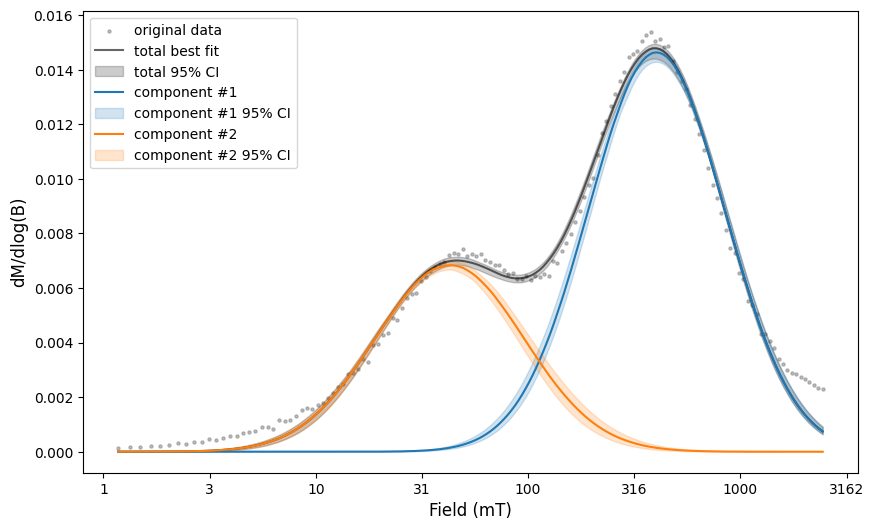

In [36]:
experiment_1_ax, experiment_1_params = rmag.backfield_MaxUnmix(result.current_experiment['smoothed_log_dc_field'],
                                                            result.current_experiment['smoothed_magn_mass_shift'],
                                                            n_comps=2, parameters=two_fits, n_resample=100, skewed=False,)

In [37]:
experiment_1_params

{'g1_amplitude': np.float64(0.77080701087066),
 'g1_center': np.float64(402.32632990880114),
 'g1_sigma': np.float64(2.0982491823868803),
 'g1_gamma': np.float64(0.0),
 'g1_amplitude_std': np.float64(0.015248521158040094),
 'g1_center_std': np.float64(1.0102134128426923),
 'g1_sigma_std': np.float64(1.0147833127095296),
 'g1_gamma_std': np.float64(0.0),
 'g2_amplitude': np.float64(0.39223535071171894),
 'g2_center': np.float64(42.67978250380338),
 'g2_sigma': np.float64(2.2398614991176635),
 'g2_gamma': np.float64(0.0),
 'g2_amplitude_std': np.float64(0.011702776597853154),
 'g2_center_std': np.float64(1.0208099314880017),
 'g2_sigma_std': np.float64(1.0254425930346818),
 'g2_gamma_std': np.float64(0.0)}

In [38]:
format_unmix_params(experiment_1_params)

,Amplitude,Bh (mT),Bh (log₁₀ mT),DP
Component,,,,
1,0.7708 ± 0.0152,402.3 ± 1.0,2.60,0.32 ± 0.01
2,0.3922 ± 0.0117,42.7 ± 1.0,1.63,0.35 ± 0.01
